In [1]:
# function to reshape features into (samples, time steps, features)
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def gen_sequence(id_df, seq_length, seq_cols):
    # Only sequences that meet the window-length are considered, no padding is used. This means for testing
    # we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    # we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

    # function to generate labels


def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)


# Gradient Solvers for FSVRG in aggregation shape (d,N
def compute_gradient_FSVRG(w, X, Y, lambda_):
    # returns a matrix of shape (d, N)
    N, d = X.shape
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)

    return YX_neg.reshape(d, N) + 2 * lambda_ * w  # (d, N)


# Gradient Solvers
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T / N

    reg = 2 * lambda_ * w
    #     set_trace()

    return g + reg


# Compute hingeloss
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d, 1)
    assert Y.shape == (N, 1)
    L = 1 - Y * (X @ w)  # (N,1)
    L[L < 0] = 0
    return L


# Cost
def cost(w, X, Y):
    return np.sum(hinge_loss(w, X, Y))


# Predict
def predict(w, X):
    return np.sign(X @ w)


# Accuracy
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects / N


# Def solver
def solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
           mini_batch=100, mem=False, return_cost=False, verbose=True, seed=-1,
           p_val=0, R_val=0, iter_print=False, T_FSVRG=1):
    N_workers = len(X)
    N_workers, N, dw = np.shape(X)
    dw = w.shape[0]

    noise_std = R_val ** 0.5

    if seed != -1:
        np.random.seed(seed)

    cost_ = np.zeros(num_iters + 1)
    acc_ = np.zeros(num_iters + 1)

    if return_cost:
        cost_[0] = cost(w, X_test, Y_test)  # return the first element in cost
        acc_[0] = accuracy(w, X_test, Y_test)  # Return the first element in accuracy

    if (optimizer == "GD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            if iter_print:
                print("..... num_iters =", i, "......")
            for worker_i in range(N_workers):
                #                 set_trace()
                gi = compute_gradient(w, X[worker_i], Y[worker_i], lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # , size=(dw, 1)
                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g / N_workers  # GD update

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

        if (verbose):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "SGD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            if iter_print:
                print("..... num_iters_SGD =", i, "......")
            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                i_ = int(N * np.random.rand(1))
                X_ = X[worker_i][[i_], :]
                Y_ = Y[worker_i][[i_], :]

                gi = compute_gradient(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # , size=(dw, 1)

                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g / N_workers  # SGD update

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

        if (verbose):
            print("SGD: Number of iterations: ", num_iters, "/", num_iters)
            print("SGD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "FSVRG"):
        T = T_FSVRG
        # epoch length
        K = math.floor(num_iters / T)
        # number of epochs, given number of iteration
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters

        # Aggregation of all gradients from the workes
        G_vec = np.zeros(shape=(dw, N))  # (d, N)
        w_k = np.zeros(shape=(dw, N_workers))  # (d, N_workers)

        for i in range(num_iters):

            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                X_ = X[worker_i]
                Y_ = Y[worker_i]
                gi = compute_gradient_FSVRG(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)

                G_vec = G_vec + gi  # aggregation of gradients in server

            G_vec = ((1 / N_workers) * G_vec) \
                    + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)
            G_ = (1 / N) * np.sum(G_vec, axis=1, keepdims=1)  # (d, 1)

            for worker_i in range(N_workers):
                w_k[:, worker_i] = w[:, 0]
                for t in range(T):
                    i_ = int(N * np.random.rand(1))
                    X_ = X[worker_i][[i_], :]  # (1, d)
                    Y_ = Y[worker_i][[i_], :]  # (1, 1)

                    g = compute_gradient(w, X_, Y_, lambda_)  # (d, 1)

                    assert g.shape == (dw, 1)
                    assert G_vec[:, [i_]].shape == (dw, 1)
                    assert G_.shape == (dw, 1)

                    w_k[:, worker_i] = w_k[:, worker_i] - alpha * (g - G_vec[:, [i_]] + G_).reshape(dw)
            w_k = w_k + (np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)) / 2000
            w = (1 / N_workers) * np.sum(w_k, axis=1, keepdims=1)

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

            if (verbose):
                print("FSVRG: Number of iterations: ", i, "/", num_iters)
                print("FSVRG: final norm: ", np.linalg.norm(g - G_vec[:, [i_]] + G_))

    if return_cost:
        return cost_, w, acc_



In [2]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHGSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM, Activation

import time
import math
import sys

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

train_df = pd.read_csv('train_FD003.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']
########################################################################################################################
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()
########################################################################################################################
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()
########################################################################################################################
w1 = 50
w0 = 30
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()
########################################################################################################################
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()
########################################################################################################################
clipResponse = True
if clipResponse:
    rulThreshold = 150
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()
########################################################################################################################
train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape
########################################################################################################################
test_df = pd.read_csv('test_FD003.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()
########################################################################################################################
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()
########################################################################################################################
truth_df = pd.read_csv('RUL_FD003.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()
########################################################################################################################
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()
########################################################################################################################
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
########################################################################################################################
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()
########################################################################################################################
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape
########################################################################################################################
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
                's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns=column_order)

Failed on importing 'resource' package, continuing wihtout it!


In [3]:
sequence_length = 20
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
# ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
# ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))
########################################################################################################################
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)
########################################################################################################################
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)
print(len(data_array_))
########################################################################################################################
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)
########################################################################################################################
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)
########################################################################################################################
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]
########################################################################################################################
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]

print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

100
100
100
100
(125, 20, 17)
(125, 1)
(125, 1)


C:\Users\alibei\AppData\Local\Temp/ipykernel_12120/3700757011.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [4]:
########################################################################################################################
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)
########################################################################################################################
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]
########################################################################################################################
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X_dic = {}
Y_dic = {}
Y_rul_dic = {}
for i in data_array_.keys():
    X_dic[i - 1] = data_array_[i].reshape(min_length, -1)
    Y_dic[i - 1] = label_array_[i]
    Y_rul_dic[i - 1] = label_array_rul_[i]

X_test_dic = {}
Y_test_dic = {}
Y_test_rul_dic = {}
for i in seq_array_test_.keys():
    X_test_dic[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test_dic[i - 1] = label_array_test_[i]
    Y_test_rul_dic[i - 1] = label_array_test_rul_[i]

C:\Users\alibei\AppData\Local\Temp/ipykernel_12120/2886126244.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


53
53
53
(125, 20, 17)
(125, 1)
(125, 1)


In [18]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
num_workers = 10
# Select random workers
index = [rand_num for rand_num in [random.randrange(*sorted([0, len(X_dic)])) for i in range(len(X_dic))]]
index = np.array(index)
index = index.reshape(1, -1)
index = index[0:math.floor(len(data_array_)/num_workers)*num_workers, :]
index = index.reshape(-1, num_workers)
X = [np.concatenate(([X_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y = [np.concatenate(([Y_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y_rul = [np.concatenate(([Y_rul_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
#X = [X_dic[i] for i in index]
#Y = [Y_dic[i] for i in index]
#Y_rul = [Y_rul_dic[i] for i in index]


X_test = np.array([[X_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, X_test_dic[0].shape[1])
Y_test = np.array([[Y_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, Y_test_dic[0].shape[1])
print(X_test.shape)
print(Y_test.shape)

(6625, 340)
(6625, 1)


In [19]:
d = X[0].shape[1]
w = np.random.rand(d, 1)
alpha = 0.01
num_iters = 3000
lambda_ = 0.1
epsilon = 0
p_val = 0
R_val = 0

In [20]:
########################################################################################################################
# Run GD
time1 = time.time()
cost_GD, w_out_GD, acc_GD = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime GD num_iters=", time2 - time1)
print("final cost with GD", cost_GD[-1])
acc_final_GD= accuracy(w_out_GD, X_test, Y_test)
print("final acc with 10 workers FedSVM_GD:", acc_final_GD)
print("-------------------------------------")


..... num_iters = 0 ......
..... num_iters = 1 ......
..... num_iters = 2 ......
..... num_iters = 3 ......
..... num_iters = 4 ......
..... num_iters = 5 ......
..... num_iters = 6 ......
..... num_iters = 7 ......
..... num_iters = 8 ......
..... num_iters = 9 ......
..... num_iters = 10 ......
..... num_iters = 11 ......
..... num_iters = 12 ......
..... num_iters = 13 ......
..... num_iters = 14 ......
..... num_iters = 15 ......
..... num_iters = 16 ......
..... num_iters = 17 ......
..... num_iters = 18 ......
..... num_iters = 19 ......
..... num_iters = 20 ......
..... num_iters = 21 ......
..... num_iters = 22 ......
..... num_iters = 23 ......
..... num_iters = 24 ......
..... num_iters = 25 ......
..... num_iters = 26 ......
..... num_iters = 27 ......
..... num_iters = 28 ......
..... num_iters = 29 ......
..... num_iters = 30 ......
..... num_iters = 31 ......
..... num_iters = 32 ......
..... num_iters = 33 ......
..... num_iters = 34 ......
..... num_iters = 35 ......
..

..... num_iters = 290 ......
..... num_iters = 291 ......
..... num_iters = 292 ......
..... num_iters = 293 ......
..... num_iters = 294 ......
..... num_iters = 295 ......
..... num_iters = 296 ......
..... num_iters = 297 ......
..... num_iters = 298 ......
..... num_iters = 299 ......
..... num_iters = 300 ......
..... num_iters = 301 ......
..... num_iters = 302 ......
..... num_iters = 303 ......
..... num_iters = 304 ......
..... num_iters = 305 ......
..... num_iters = 306 ......
..... num_iters = 307 ......
..... num_iters = 308 ......
..... num_iters = 309 ......
..... num_iters = 310 ......
..... num_iters = 311 ......
..... num_iters = 312 ......
..... num_iters = 313 ......
..... num_iters = 314 ......
..... num_iters = 315 ......
..... num_iters = 316 ......
..... num_iters = 317 ......
..... num_iters = 318 ......
..... num_iters = 319 ......
..... num_iters = 320 ......
..... num_iters = 321 ......
..... num_iters = 322 ......
..... num_iters = 323 ......
..... num_iter

..... num_iters = 573 ......
..... num_iters = 574 ......
..... num_iters = 575 ......
..... num_iters = 576 ......
..... num_iters = 577 ......
..... num_iters = 578 ......
..... num_iters = 579 ......
..... num_iters = 580 ......
..... num_iters = 581 ......
..... num_iters = 582 ......
..... num_iters = 583 ......
..... num_iters = 584 ......
..... num_iters = 585 ......
..... num_iters = 586 ......
..... num_iters = 587 ......
..... num_iters = 588 ......
..... num_iters = 589 ......
..... num_iters = 590 ......
..... num_iters = 591 ......
..... num_iters = 592 ......
..... num_iters = 593 ......
..... num_iters = 594 ......
..... num_iters = 595 ......
..... num_iters = 596 ......
..... num_iters = 597 ......
..... num_iters = 598 ......
..... num_iters = 599 ......
..... num_iters = 600 ......
..... num_iters = 601 ......
..... num_iters = 602 ......
..... num_iters = 603 ......
..... num_iters = 604 ......
..... num_iters = 605 ......
..... num_iters = 606 ......
..... num_iter

..... num_iters = 857 ......
..... num_iters = 858 ......
..... num_iters = 859 ......
..... num_iters = 860 ......
..... num_iters = 861 ......
..... num_iters = 862 ......
..... num_iters = 863 ......
..... num_iters = 864 ......
..... num_iters = 865 ......
..... num_iters = 866 ......
..... num_iters = 867 ......
..... num_iters = 868 ......
..... num_iters = 869 ......
..... num_iters = 870 ......
..... num_iters = 871 ......
..... num_iters = 872 ......
..... num_iters = 873 ......
..... num_iters = 874 ......
..... num_iters = 875 ......
..... num_iters = 876 ......
..... num_iters = 877 ......
..... num_iters = 878 ......
..... num_iters = 879 ......
..... num_iters = 880 ......
..... num_iters = 881 ......
..... num_iters = 882 ......
..... num_iters = 883 ......
..... num_iters = 884 ......
..... num_iters = 885 ......
..... num_iters = 886 ......
..... num_iters = 887 ......
..... num_iters = 888 ......
..... num_iters = 889 ......
..... num_iters = 890 ......
..... num_iter

..... num_iters = 1136 ......
..... num_iters = 1137 ......
..... num_iters = 1138 ......
..... num_iters = 1139 ......
..... num_iters = 1140 ......
..... num_iters = 1141 ......
..... num_iters = 1142 ......
..... num_iters = 1143 ......
..... num_iters = 1144 ......
..... num_iters = 1145 ......
..... num_iters = 1146 ......
..... num_iters = 1147 ......
..... num_iters = 1148 ......
..... num_iters = 1149 ......
..... num_iters = 1150 ......
..... num_iters = 1151 ......
..... num_iters = 1152 ......
..... num_iters = 1153 ......
..... num_iters = 1154 ......
..... num_iters = 1155 ......
..... num_iters = 1156 ......
..... num_iters = 1157 ......
..... num_iters = 1158 ......
..... num_iters = 1159 ......
..... num_iters = 1160 ......
..... num_iters = 1161 ......
..... num_iters = 1162 ......
..... num_iters = 1163 ......
..... num_iters = 1164 ......
..... num_iters = 1165 ......
..... num_iters = 1166 ......
..... num_iters = 1167 ......
..... num_iters = 1168 ......
..... num_

..... num_iters = 1412 ......
..... num_iters = 1413 ......
..... num_iters = 1414 ......
..... num_iters = 1415 ......
..... num_iters = 1416 ......
..... num_iters = 1417 ......
..... num_iters = 1418 ......
..... num_iters = 1419 ......
..... num_iters = 1420 ......
..... num_iters = 1421 ......
..... num_iters = 1422 ......
..... num_iters = 1423 ......
..... num_iters = 1424 ......
..... num_iters = 1425 ......
..... num_iters = 1426 ......
..... num_iters = 1427 ......
..... num_iters = 1428 ......
..... num_iters = 1429 ......
..... num_iters = 1430 ......
..... num_iters = 1431 ......
..... num_iters = 1432 ......
..... num_iters = 1433 ......
..... num_iters = 1434 ......
..... num_iters = 1435 ......
..... num_iters = 1436 ......
..... num_iters = 1437 ......
..... num_iters = 1438 ......
..... num_iters = 1439 ......
..... num_iters = 1440 ......
..... num_iters = 1441 ......
..... num_iters = 1442 ......
..... num_iters = 1443 ......
..... num_iters = 1444 ......
..... num_

..... num_iters = 1691 ......
..... num_iters = 1692 ......
..... num_iters = 1693 ......
..... num_iters = 1694 ......
..... num_iters = 1695 ......
..... num_iters = 1696 ......
..... num_iters = 1697 ......
..... num_iters = 1698 ......
..... num_iters = 1699 ......
..... num_iters = 1700 ......
..... num_iters = 1701 ......
..... num_iters = 1702 ......
..... num_iters = 1703 ......
..... num_iters = 1704 ......
..... num_iters = 1705 ......
..... num_iters = 1706 ......
..... num_iters = 1707 ......
..... num_iters = 1708 ......
..... num_iters = 1709 ......
..... num_iters = 1710 ......
..... num_iters = 1711 ......
..... num_iters = 1712 ......
..... num_iters = 1713 ......
..... num_iters = 1714 ......
..... num_iters = 1715 ......
..... num_iters = 1716 ......
..... num_iters = 1717 ......
..... num_iters = 1718 ......
..... num_iters = 1719 ......
..... num_iters = 1720 ......
..... num_iters = 1721 ......
..... num_iters = 1722 ......
..... num_iters = 1723 ......
..... num_

..... num_iters = 1973 ......
..... num_iters = 1974 ......
..... num_iters = 1975 ......
..... num_iters = 1976 ......
..... num_iters = 1977 ......
..... num_iters = 1978 ......
..... num_iters = 1979 ......
..... num_iters = 1980 ......
..... num_iters = 1981 ......
..... num_iters = 1982 ......
..... num_iters = 1983 ......
..... num_iters = 1984 ......
..... num_iters = 1985 ......
..... num_iters = 1986 ......
..... num_iters = 1987 ......
..... num_iters = 1988 ......
..... num_iters = 1989 ......
..... num_iters = 1990 ......
..... num_iters = 1991 ......
..... num_iters = 1992 ......
..... num_iters = 1993 ......
..... num_iters = 1994 ......
..... num_iters = 1995 ......
..... num_iters = 1996 ......
..... num_iters = 1997 ......
..... num_iters = 1998 ......
..... num_iters = 1999 ......
..... num_iters = 2000 ......
..... num_iters = 2001 ......
..... num_iters = 2002 ......
..... num_iters = 2003 ......
..... num_iters = 2004 ......
..... num_iters = 2005 ......
..... num_

..... num_iters = 2251 ......
..... num_iters = 2252 ......
..... num_iters = 2253 ......
..... num_iters = 2254 ......
..... num_iters = 2255 ......
..... num_iters = 2256 ......
..... num_iters = 2257 ......
..... num_iters = 2258 ......
..... num_iters = 2259 ......
..... num_iters = 2260 ......
..... num_iters = 2261 ......
..... num_iters = 2262 ......
..... num_iters = 2263 ......
..... num_iters = 2264 ......
..... num_iters = 2265 ......
..... num_iters = 2266 ......
..... num_iters = 2267 ......
..... num_iters = 2268 ......
..... num_iters = 2269 ......
..... num_iters = 2270 ......
..... num_iters = 2271 ......
..... num_iters = 2272 ......
..... num_iters = 2273 ......
..... num_iters = 2274 ......
..... num_iters = 2275 ......
..... num_iters = 2276 ......
..... num_iters = 2277 ......
..... num_iters = 2278 ......
..... num_iters = 2279 ......
..... num_iters = 2280 ......
..... num_iters = 2281 ......
..... num_iters = 2282 ......
..... num_iters = 2283 ......
..... num_

..... num_iters = 2532 ......
..... num_iters = 2533 ......
..... num_iters = 2534 ......
..... num_iters = 2535 ......
..... num_iters = 2536 ......
..... num_iters = 2537 ......
..... num_iters = 2538 ......
..... num_iters = 2539 ......
..... num_iters = 2540 ......
..... num_iters = 2541 ......
..... num_iters = 2542 ......
..... num_iters = 2543 ......
..... num_iters = 2544 ......
..... num_iters = 2545 ......
..... num_iters = 2546 ......
..... num_iters = 2547 ......
..... num_iters = 2548 ......
..... num_iters = 2549 ......
..... num_iters = 2550 ......
..... num_iters = 2551 ......
..... num_iters = 2552 ......
..... num_iters = 2553 ......
..... num_iters = 2554 ......
..... num_iters = 2555 ......
..... num_iters = 2556 ......
..... num_iters = 2557 ......
..... num_iters = 2558 ......
..... num_iters = 2559 ......
..... num_iters = 2560 ......
..... num_iters = 2561 ......
..... num_iters = 2562 ......
..... num_iters = 2563 ......
..... num_iters = 2564 ......
..... num_

..... num_iters = 2807 ......
..... num_iters = 2808 ......
..... num_iters = 2809 ......
..... num_iters = 2810 ......
..... num_iters = 2811 ......
..... num_iters = 2812 ......
..... num_iters = 2813 ......
..... num_iters = 2814 ......
..... num_iters = 2815 ......
..... num_iters = 2816 ......
..... num_iters = 2817 ......
..... num_iters = 2818 ......
..... num_iters = 2819 ......
..... num_iters = 2820 ......
..... num_iters = 2821 ......
..... num_iters = 2822 ......
..... num_iters = 2823 ......
..... num_iters = 2824 ......
..... num_iters = 2825 ......
..... num_iters = 2826 ......
..... num_iters = 2827 ......
..... num_iters = 2828 ......
..... num_iters = 2829 ......
..... num_iters = 2830 ......
..... num_iters = 2831 ......
..... num_iters = 2832 ......
..... num_iters = 2833 ......
..... num_iters = 2834 ......
..... num_iters = 2835 ......
..... num_iters = 2836 ......
..... num_iters = 2837 ......
..... num_iters = 2838 ......
..... num_iters = 2839 ......
..... num_

In [21]:
########################################################################################################################
# Run SGD
time1 = time.time()
cost_SGD, w_out_SGD, acc_GD = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="SGD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime SGD num_iters=", time2 - time1)
print("final cost with SGD", cost_SGD[-1])
acc_final_SGD = accuracy(w_out_SGD, X_test, Y_test)
print("final acc with 10 workers FedSVM_SGD:", acc_final_SGD)
print("-------------------------------------")

..... num_iters_SGD = 0 ......
..... num_iters_SGD = 1 ......
..... num_iters_SGD = 2 ......
..... num_iters_SGD = 3 ......
..... num_iters_SGD = 4 ......
..... num_iters_SGD = 5 ......
..... num_iters_SGD = 6 ......
..... num_iters_SGD = 7 ......
..... num_iters_SGD = 8 ......
..... num_iters_SGD = 9 ......
..... num_iters_SGD = 10 ......
..... num_iters_SGD = 11 ......
..... num_iters_SGD = 12 ......
..... num_iters_SGD = 13 ......
..... num_iters_SGD = 14 ......
..... num_iters_SGD = 15 ......
..... num_iters_SGD = 16 ......
..... num_iters_SGD = 17 ......
..... num_iters_SGD = 18 ......
..... num_iters_SGD = 19 ......
..... num_iters_SGD = 20 ......
..... num_iters_SGD = 21 ......
..... num_iters_SGD = 22 ......
..... num_iters_SGD = 23 ......
..... num_iters_SGD = 24 ......
..... num_iters_SGD = 25 ......
..... num_iters_SGD = 26 ......
..... num_iters_SGD = 27 ......
..... num_iters_SGD = 28 ......
..... num_iters_SGD = 29 ......
..... num_iters_SGD = 30 ......
..... num_iters_SG

..... num_iters_SGD = 271 ......
..... num_iters_SGD = 272 ......
..... num_iters_SGD = 273 ......
..... num_iters_SGD = 274 ......
..... num_iters_SGD = 275 ......
..... num_iters_SGD = 276 ......
..... num_iters_SGD = 277 ......
..... num_iters_SGD = 278 ......
..... num_iters_SGD = 279 ......
..... num_iters_SGD = 280 ......
..... num_iters_SGD = 281 ......
..... num_iters_SGD = 282 ......
..... num_iters_SGD = 283 ......
..... num_iters_SGD = 284 ......
..... num_iters_SGD = 285 ......
..... num_iters_SGD = 286 ......
..... num_iters_SGD = 287 ......
..... num_iters_SGD = 288 ......
..... num_iters_SGD = 289 ......
..... num_iters_SGD = 290 ......
..... num_iters_SGD = 291 ......
..... num_iters_SGD = 292 ......
..... num_iters_SGD = 293 ......
..... num_iters_SGD = 294 ......
..... num_iters_SGD = 295 ......
..... num_iters_SGD = 296 ......
..... num_iters_SGD = 297 ......
..... num_iters_SGD = 298 ......
..... num_iters_SGD = 299 ......
..... num_iters_SGD = 300 ......
..... num_

..... num_iters_SGD = 543 ......
..... num_iters_SGD = 544 ......
..... num_iters_SGD = 545 ......
..... num_iters_SGD = 546 ......
..... num_iters_SGD = 547 ......
..... num_iters_SGD = 548 ......
..... num_iters_SGD = 549 ......
..... num_iters_SGD = 550 ......
..... num_iters_SGD = 551 ......
..... num_iters_SGD = 552 ......
..... num_iters_SGD = 553 ......
..... num_iters_SGD = 554 ......
..... num_iters_SGD = 555 ......
..... num_iters_SGD = 556 ......
..... num_iters_SGD = 557 ......
..... num_iters_SGD = 558 ......
..... num_iters_SGD = 559 ......
..... num_iters_SGD = 560 ......
..... num_iters_SGD = 561 ......
..... num_iters_SGD = 562 ......
..... num_iters_SGD = 563 ......
..... num_iters_SGD = 564 ......
..... num_iters_SGD = 565 ......
..... num_iters_SGD = 566 ......
..... num_iters_SGD = 567 ......
..... num_iters_SGD = 568 ......
..... num_iters_SGD = 569 ......
..... num_iters_SGD = 570 ......
..... num_iters_SGD = 571 ......
..... num_iters_SGD = 572 ......
..... num_

..... num_iters_SGD = 792 ......
..... num_iters_SGD = 793 ......
..... num_iters_SGD = 794 ......
..... num_iters_SGD = 795 ......
..... num_iters_SGD = 796 ......
..... num_iters_SGD = 797 ......
..... num_iters_SGD = 798 ......
..... num_iters_SGD = 799 ......
..... num_iters_SGD = 800 ......
..... num_iters_SGD = 801 ......
..... num_iters_SGD = 802 ......
..... num_iters_SGD = 803 ......
..... num_iters_SGD = 804 ......
..... num_iters_SGD = 805 ......
..... num_iters_SGD = 806 ......
..... num_iters_SGD = 807 ......
..... num_iters_SGD = 808 ......
..... num_iters_SGD = 809 ......
..... num_iters_SGD = 810 ......
..... num_iters_SGD = 811 ......
..... num_iters_SGD = 812 ......
..... num_iters_SGD = 813 ......
..... num_iters_SGD = 814 ......
..... num_iters_SGD = 815 ......
..... num_iters_SGD = 816 ......
..... num_iters_SGD = 817 ......
..... num_iters_SGD = 818 ......
..... num_iters_SGD = 819 ......
..... num_iters_SGD = 820 ......
..... num_iters_SGD = 821 ......
..... num_

..... num_iters_SGD = 1040 ......
..... num_iters_SGD = 1041 ......
..... num_iters_SGD = 1042 ......
..... num_iters_SGD = 1043 ......
..... num_iters_SGD = 1044 ......
..... num_iters_SGD = 1045 ......
..... num_iters_SGD = 1046 ......
..... num_iters_SGD = 1047 ......
..... num_iters_SGD = 1048 ......
..... num_iters_SGD = 1049 ......
..... num_iters_SGD = 1050 ......
..... num_iters_SGD = 1051 ......
..... num_iters_SGD = 1052 ......
..... num_iters_SGD = 1053 ......
..... num_iters_SGD = 1054 ......
..... num_iters_SGD = 1055 ......
..... num_iters_SGD = 1056 ......
..... num_iters_SGD = 1057 ......
..... num_iters_SGD = 1058 ......
..... num_iters_SGD = 1059 ......
..... num_iters_SGD = 1060 ......
..... num_iters_SGD = 1061 ......
..... num_iters_SGD = 1062 ......
..... num_iters_SGD = 1063 ......
..... num_iters_SGD = 1064 ......
..... num_iters_SGD = 1065 ......
..... num_iters_SGD = 1066 ......
..... num_iters_SGD = 1067 ......
..... num_iters_SGD = 1068 ......
..... num_iter

..... num_iters_SGD = 1286 ......
..... num_iters_SGD = 1287 ......
..... num_iters_SGD = 1288 ......
..... num_iters_SGD = 1289 ......
..... num_iters_SGD = 1290 ......
..... num_iters_SGD = 1291 ......
..... num_iters_SGD = 1292 ......
..... num_iters_SGD = 1293 ......
..... num_iters_SGD = 1294 ......
..... num_iters_SGD = 1295 ......
..... num_iters_SGD = 1296 ......
..... num_iters_SGD = 1297 ......
..... num_iters_SGD = 1298 ......
..... num_iters_SGD = 1299 ......
..... num_iters_SGD = 1300 ......
..... num_iters_SGD = 1301 ......
..... num_iters_SGD = 1302 ......
..... num_iters_SGD = 1303 ......
..... num_iters_SGD = 1304 ......
..... num_iters_SGD = 1305 ......
..... num_iters_SGD = 1306 ......
..... num_iters_SGD = 1307 ......
..... num_iters_SGD = 1308 ......
..... num_iters_SGD = 1309 ......
..... num_iters_SGD = 1310 ......
..... num_iters_SGD = 1311 ......
..... num_iters_SGD = 1312 ......
..... num_iters_SGD = 1313 ......
..... num_iters_SGD = 1314 ......
..... num_iter

..... num_iters_SGD = 1533 ......
..... num_iters_SGD = 1534 ......
..... num_iters_SGD = 1535 ......
..... num_iters_SGD = 1536 ......
..... num_iters_SGD = 1537 ......
..... num_iters_SGD = 1538 ......
..... num_iters_SGD = 1539 ......
..... num_iters_SGD = 1540 ......
..... num_iters_SGD = 1541 ......
..... num_iters_SGD = 1542 ......
..... num_iters_SGD = 1543 ......
..... num_iters_SGD = 1544 ......
..... num_iters_SGD = 1545 ......
..... num_iters_SGD = 1546 ......
..... num_iters_SGD = 1547 ......
..... num_iters_SGD = 1548 ......
..... num_iters_SGD = 1549 ......
..... num_iters_SGD = 1550 ......
..... num_iters_SGD = 1551 ......
..... num_iters_SGD = 1552 ......
..... num_iters_SGD = 1553 ......
..... num_iters_SGD = 1554 ......
..... num_iters_SGD = 1555 ......
..... num_iters_SGD = 1556 ......
..... num_iters_SGD = 1557 ......
..... num_iters_SGD = 1558 ......
..... num_iters_SGD = 1559 ......
..... num_iters_SGD = 1560 ......
..... num_iters_SGD = 1561 ......
..... num_iter

..... num_iters_SGD = 1782 ......
..... num_iters_SGD = 1783 ......
..... num_iters_SGD = 1784 ......
..... num_iters_SGD = 1785 ......
..... num_iters_SGD = 1786 ......
..... num_iters_SGD = 1787 ......
..... num_iters_SGD = 1788 ......
..... num_iters_SGD = 1789 ......
..... num_iters_SGD = 1790 ......
..... num_iters_SGD = 1791 ......
..... num_iters_SGD = 1792 ......
..... num_iters_SGD = 1793 ......
..... num_iters_SGD = 1794 ......
..... num_iters_SGD = 1795 ......
..... num_iters_SGD = 1796 ......
..... num_iters_SGD = 1797 ......
..... num_iters_SGD = 1798 ......
..... num_iters_SGD = 1799 ......
..... num_iters_SGD = 1800 ......
..... num_iters_SGD = 1801 ......
..... num_iters_SGD = 1802 ......
..... num_iters_SGD = 1803 ......
..... num_iters_SGD = 1804 ......
..... num_iters_SGD = 1805 ......
..... num_iters_SGD = 1806 ......
..... num_iters_SGD = 1807 ......
..... num_iters_SGD = 1808 ......
..... num_iters_SGD = 1809 ......
..... num_iters_SGD = 1810 ......
..... num_iter

..... num_iters_SGD = 2030 ......
..... num_iters_SGD = 2031 ......
..... num_iters_SGD = 2032 ......
..... num_iters_SGD = 2033 ......
..... num_iters_SGD = 2034 ......
..... num_iters_SGD = 2035 ......
..... num_iters_SGD = 2036 ......
..... num_iters_SGD = 2037 ......
..... num_iters_SGD = 2038 ......
..... num_iters_SGD = 2039 ......
..... num_iters_SGD = 2040 ......
..... num_iters_SGD = 2041 ......
..... num_iters_SGD = 2042 ......
..... num_iters_SGD = 2043 ......
..... num_iters_SGD = 2044 ......
..... num_iters_SGD = 2045 ......
..... num_iters_SGD = 2046 ......
..... num_iters_SGD = 2047 ......
..... num_iters_SGD = 2048 ......
..... num_iters_SGD = 2049 ......
..... num_iters_SGD = 2050 ......
..... num_iters_SGD = 2051 ......
..... num_iters_SGD = 2052 ......
..... num_iters_SGD = 2053 ......
..... num_iters_SGD = 2054 ......
..... num_iters_SGD = 2055 ......
..... num_iters_SGD = 2056 ......
..... num_iters_SGD = 2057 ......
..... num_iters_SGD = 2058 ......
..... num_iter

..... num_iters_SGD = 2279 ......
..... num_iters_SGD = 2280 ......
..... num_iters_SGD = 2281 ......
..... num_iters_SGD = 2282 ......
..... num_iters_SGD = 2283 ......
..... num_iters_SGD = 2284 ......
..... num_iters_SGD = 2285 ......
..... num_iters_SGD = 2286 ......
..... num_iters_SGD = 2287 ......
..... num_iters_SGD = 2288 ......
..... num_iters_SGD = 2289 ......
..... num_iters_SGD = 2290 ......
..... num_iters_SGD = 2291 ......
..... num_iters_SGD = 2292 ......
..... num_iters_SGD = 2293 ......
..... num_iters_SGD = 2294 ......
..... num_iters_SGD = 2295 ......
..... num_iters_SGD = 2296 ......
..... num_iters_SGD = 2297 ......
..... num_iters_SGD = 2298 ......
..... num_iters_SGD = 2299 ......
..... num_iters_SGD = 2300 ......
..... num_iters_SGD = 2301 ......
..... num_iters_SGD = 2302 ......
..... num_iters_SGD = 2303 ......
..... num_iters_SGD = 2304 ......
..... num_iters_SGD = 2305 ......
..... num_iters_SGD = 2306 ......
..... num_iters_SGD = 2307 ......
..... num_iter

..... num_iters_SGD = 2527 ......
..... num_iters_SGD = 2528 ......
..... num_iters_SGD = 2529 ......
..... num_iters_SGD = 2530 ......
..... num_iters_SGD = 2531 ......
..... num_iters_SGD = 2532 ......
..... num_iters_SGD = 2533 ......
..... num_iters_SGD = 2534 ......
..... num_iters_SGD = 2535 ......
..... num_iters_SGD = 2536 ......
..... num_iters_SGD = 2537 ......
..... num_iters_SGD = 2538 ......
..... num_iters_SGD = 2539 ......
..... num_iters_SGD = 2540 ......
..... num_iters_SGD = 2541 ......
..... num_iters_SGD = 2542 ......
..... num_iters_SGD = 2543 ......
..... num_iters_SGD = 2544 ......
..... num_iters_SGD = 2545 ......
..... num_iters_SGD = 2546 ......
..... num_iters_SGD = 2547 ......
..... num_iters_SGD = 2548 ......
..... num_iters_SGD = 2549 ......
..... num_iters_SGD = 2550 ......
..... num_iters_SGD = 2551 ......
..... num_iters_SGD = 2552 ......
..... num_iters_SGD = 2553 ......
..... num_iters_SGD = 2554 ......
..... num_iters_SGD = 2555 ......
..... num_iter

..... num_iters_SGD = 2775 ......
..... num_iters_SGD = 2776 ......
..... num_iters_SGD = 2777 ......
..... num_iters_SGD = 2778 ......
..... num_iters_SGD = 2779 ......
..... num_iters_SGD = 2780 ......
..... num_iters_SGD = 2781 ......
..... num_iters_SGD = 2782 ......
..... num_iters_SGD = 2783 ......
..... num_iters_SGD = 2784 ......
..... num_iters_SGD = 2785 ......
..... num_iters_SGD = 2786 ......
..... num_iters_SGD = 2787 ......
..... num_iters_SGD = 2788 ......
..... num_iters_SGD = 2789 ......
..... num_iters_SGD = 2790 ......
..... num_iters_SGD = 2791 ......
..... num_iters_SGD = 2792 ......
..... num_iters_SGD = 2793 ......
..... num_iters_SGD = 2794 ......
..... num_iters_SGD = 2795 ......
..... num_iters_SGD = 2796 ......
..... num_iters_SGD = 2797 ......
..... num_iters_SGD = 2798 ......
..... num_iters_SGD = 2799 ......
..... num_iters_SGD = 2800 ......
..... num_iters_SGD = 2801 ......
..... num_iters_SGD = 2802 ......
..... num_iters_SGD = 2803 ......
..... num_iter

In [22]:
########################################################################################################################
# Run FSVRG
time1 = time.time()
cost_FSVRG, w_out_FSVRG, acc_FSVRG = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="FSVRG",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime FSVRG num_iters=", time2 - time1)
print("final cost with FSVRG", cost_SGD[-1])
acc_final_FSVRG = accuracy(w_out_FSVRG, X_test, Y_test)
print("final acc with 10 workers FedSVM_FSVRG:", acc_final_FSVRG)
print("-------------------------------------")


FSVRG: Number of iterations:  0 / 3000
FSVRG: final norm:  3.4209589358461647
FSVRG: Number of iterations:  1 / 3000
FSVRG: final norm:  10.227484967842894
FSVRG: Number of iterations:  2 / 3000
FSVRG: final norm:  3.5748097718486656
FSVRG: Number of iterations:  3 / 3000
FSVRG: final norm:  11.025919715046598
FSVRG: Number of iterations:  4 / 3000
FSVRG: final norm:  10.470566136619086
FSVRG: Number of iterations:  5 / 3000
FSVRG: final norm:  3.7010081164985023
FSVRG: Number of iterations:  6 / 3000
FSVRG: final norm:  3.901526233505
FSVRG: Number of iterations:  7 / 3000
FSVRG: final norm:  11.37940572203098
FSVRG: Number of iterations:  8 / 3000
FSVRG: final norm:  3.58563611843585
FSVRG: Number of iterations:  9 / 3000
FSVRG: final norm:  10.422089670940846
FSVRG: Number of iterations:  10 / 3000
FSVRG: final norm:  10.744090494536794
FSVRG: Number of iterations:  11 / 3000
FSVRG: final norm:  3.77031818157521
FSVRG: Number of iterations:  12 / 3000
FSVRG: final norm:  10.51653779

FSVRG: Number of iterations:  106 / 3000
FSVRG: final norm:  9.544291800870056
FSVRG: Number of iterations:  107 / 3000
FSVRG: final norm:  3.076619619660666
FSVRG: Number of iterations:  108 / 3000
FSVRG: final norm:  9.029027820111915
FSVRG: Number of iterations:  109 / 3000
FSVRG: final norm:  3.241447462798032
FSVRG: Number of iterations:  110 / 3000
FSVRG: final norm:  3.112726109732122
FSVRG: Number of iterations:  111 / 3000
FSVRG: final norm:  3.034442176002097
FSVRG: Number of iterations:  112 / 3000
FSVRG: final norm:  3.3481421442183
FSVRG: Number of iterations:  113 / 3000
FSVRG: final norm:  10.04104805576764
FSVRG: Number of iterations:  114 / 3000
FSVRG: final norm:  9.088173306445265
FSVRG: Number of iterations:  115 / 3000
FSVRG: final norm:  11.048756409574795
FSVRG: Number of iterations:  116 / 3000
FSVRG: final norm:  8.686344119054906
FSVRG: Number of iterations:  117 / 3000
FSVRG: final norm:  9.907768784359511
FSVRG: Number of iterations:  118 / 3000
FSVRG: final

FSVRG: Number of iterations:  210 / 3000
FSVRG: final norm:  9.426526718243085
FSVRG: Number of iterations:  211 / 3000
FSVRG: final norm:  3.0166817201775196
FSVRG: Number of iterations:  212 / 3000
FSVRG: final norm:  3.0598532085216497
FSVRG: Number of iterations:  213 / 3000
FSVRG: final norm:  8.887418527904437
FSVRG: Number of iterations:  214 / 3000
FSVRG: final norm:  8.262534871132738
FSVRG: Number of iterations:  215 / 3000
FSVRG: final norm:  9.333809991028932
FSVRG: Number of iterations:  216 / 3000
FSVRG: final norm:  9.680042991514439
FSVRG: Number of iterations:  217 / 3000
FSVRG: final norm:  9.347291495527314
FSVRG: Number of iterations:  218 / 3000
FSVRG: final norm:  9.414988444971057
FSVRG: Number of iterations:  219 / 3000
FSVRG: final norm:  9.334027306885421
FSVRG: Number of iterations:  220 / 3000
FSVRG: final norm:  3.125570544731939
FSVRG: Number of iterations:  221 / 3000
FSVRG: final norm:  9.979741119870537
FSVRG: Number of iterations:  222 / 3000
FSVRG: fi

FSVRG: Number of iterations:  316 / 3000
FSVRG: final norm:  9.947019815300767
FSVRG: Number of iterations:  317 / 3000
FSVRG: final norm:  2.965557569000451
FSVRG: Number of iterations:  318 / 3000
FSVRG: final norm:  8.953470104507316
FSVRG: Number of iterations:  319 / 3000
FSVRG: final norm:  3.1085612354812935
FSVRG: Number of iterations:  320 / 3000
FSVRG: final norm:  2.9827582310868803
FSVRG: Number of iterations:  321 / 3000
FSVRG: final norm:  9.037695961570396
FSVRG: Number of iterations:  322 / 3000
FSVRG: final norm:  9.214333919571846
FSVRG: Number of iterations:  323 / 3000
FSVRG: final norm:  10.139190164059903
FSVRG: Number of iterations:  324 / 3000
FSVRG: final norm:  3.3360727075690524
FSVRG: Number of iterations:  325 / 3000
FSVRG: final norm:  3.0061068047838453
FSVRG: Number of iterations:  326 / 3000
FSVRG: final norm:  8.757011049658482
FSVRG: Number of iterations:  327 / 3000
FSVRG: final norm:  10.368416853071926
FSVRG: Number of iterations:  328 / 3000
FSVRG

FSVRG: Number of iterations:  420 / 3000
FSVRG: final norm:  11.346410347521353
FSVRG: Number of iterations:  421 / 3000
FSVRG: final norm:  9.31733242361638
FSVRG: Number of iterations:  422 / 3000
FSVRG: final norm:  9.17306415696383
FSVRG: Number of iterations:  423 / 3000
FSVRG: final norm:  9.139529599196369
FSVRG: Number of iterations:  424 / 3000
FSVRG: final norm:  3.070422537307709
FSVRG: Number of iterations:  425 / 3000
FSVRG: final norm:  3.006088892259073
FSVRG: Number of iterations:  426 / 3000
FSVRG: final norm:  9.058807666345325
FSVRG: Number of iterations:  427 / 3000
FSVRG: final norm:  8.667437999881066
FSVRG: Number of iterations:  428 / 3000
FSVRG: final norm:  3.167637528083892
FSVRG: Number of iterations:  429 / 3000
FSVRG: final norm:  3.1028558737433047
FSVRG: Number of iterations:  430 / 3000
FSVRG: final norm:  9.628970980387109
FSVRG: Number of iterations:  431 / 3000
FSVRG: final norm:  9.504196051921493
FSVRG: Number of iterations:  432 / 3000
FSVRG: fina

FSVRG: Number of iterations:  524 / 3000
FSVRG: final norm:  3.0346535792147167
FSVRG: Number of iterations:  525 / 3000
FSVRG: final norm:  9.095553983881622
FSVRG: Number of iterations:  526 / 3000
FSVRG: final norm:  2.9251919793814873
FSVRG: Number of iterations:  527 / 3000
FSVRG: final norm:  3.0905129068589297
FSVRG: Number of iterations:  528 / 3000
FSVRG: final norm:  9.682703259984
FSVRG: Number of iterations:  529 / 3000
FSVRG: final norm:  3.108737117389548
FSVRG: Number of iterations:  530 / 3000
FSVRG: final norm:  3.5279536717491022
FSVRG: Number of iterations:  531 / 3000
FSVRG: final norm:  4.182683208801634
FSVRG: Number of iterations:  532 / 3000
FSVRG: final norm:  9.117950110589607
FSVRG: Number of iterations:  533 / 3000
FSVRG: final norm:  9.342153489047021
FSVRG: Number of iterations:  534 / 3000
FSVRG: final norm:  4.312536249648497
FSVRG: Number of iterations:  535 / 3000
FSVRG: final norm:  9.585658753641448
FSVRG: Number of iterations:  536 / 3000
FSVRG: fin

FSVRG: final norm:  9.172926238373009
FSVRG: Number of iterations:  629 / 3000
FSVRG: final norm:  9.430328705595613
FSVRG: Number of iterations:  630 / 3000
FSVRG: final norm:  3.0870279256625843
FSVRG: Number of iterations:  631 / 3000
FSVRG: final norm:  9.85458179777159
FSVRG: Number of iterations:  632 / 3000
FSVRG: final norm:  3.273198235952612
FSVRG: Number of iterations:  633 / 3000
FSVRG: final norm:  9.174840728331375
FSVRG: Number of iterations:  634 / 3000
FSVRG: final norm:  9.253600958531683
FSVRG: Number of iterations:  635 / 3000
FSVRG: final norm:  3.0410568663984643
FSVRG: Number of iterations:  636 / 3000
FSVRG: final norm:  3.0793906658982557
FSVRG: Number of iterations:  637 / 3000
FSVRG: final norm:  9.291318293119076
FSVRG: Number of iterations:  638 / 3000
FSVRG: final norm:  9.514716865358416
FSVRG: Number of iterations:  639 / 3000
FSVRG: final norm:  9.798727888639121
FSVRG: Number of iterations:  640 / 3000
FSVRG: final norm:  9.41597274610435
FSVRG: Number

FSVRG: Number of iterations:  734 / 3000
FSVRG: final norm:  9.540556398570658
FSVRG: Number of iterations:  735 / 3000
FSVRG: final norm:  2.9743219687087077
FSVRG: Number of iterations:  736 / 3000
FSVRG: final norm:  9.91801920019428
FSVRG: Number of iterations:  737 / 3000
FSVRG: final norm:  9.85475083299204
FSVRG: Number of iterations:  738 / 3000
FSVRG: final norm:  11.509300473791594
FSVRG: Number of iterations:  739 / 3000
FSVRG: final norm:  9.221293101020356
FSVRG: Number of iterations:  740 / 3000
FSVRG: final norm:  9.246342298973005
FSVRG: Number of iterations:  741 / 3000
FSVRG: final norm:  9.676319080591663
FSVRG: Number of iterations:  742 / 3000
FSVRG: final norm:  3.0441178255674957
FSVRG: Number of iterations:  743 / 3000
FSVRG: final norm:  3.045869465686504
FSVRG: Number of iterations:  744 / 3000
FSVRG: final norm:  9.444237604738822
FSVRG: Number of iterations:  745 / 3000
FSVRG: final norm:  9.3829775261078
FSVRG: Number of iterations:  746 / 3000
FSVRG: final

FSVRG: Number of iterations:  842 / 3000
FSVRG: final norm:  8.904145700036041
FSVRG: Number of iterations:  843 / 3000
FSVRG: final norm:  10.532461617290004
FSVRG: Number of iterations:  844 / 3000
FSVRG: final norm:  9.851465469648344
FSVRG: Number of iterations:  845 / 3000
FSVRG: final norm:  9.842354452342086
FSVRG: Number of iterations:  846 / 3000
FSVRG: final norm:  10.69017954637314
FSVRG: Number of iterations:  847 / 3000
FSVRG: final norm:  3.017534962483021
FSVRG: Number of iterations:  848 / 3000
FSVRG: final norm:  8.892593163570607
FSVRG: Number of iterations:  849 / 3000
FSVRG: final norm:  8.744878016128887
FSVRG: Number of iterations:  850 / 3000
FSVRG: final norm:  2.940187580760223
FSVRG: Number of iterations:  851 / 3000
FSVRG: final norm:  2.975406132930477
FSVRG: Number of iterations:  852 / 3000
FSVRG: final norm:  3.2010954499823296
FSVRG: Number of iterations:  853 / 3000
FSVRG: final norm:  9.20147624281838
FSVRG: Number of iterations:  854 / 3000
FSVRG: fin

FSVRG: Number of iterations:  949 / 3000
FSVRG: final norm:  3.0753757714799055
FSVRG: Number of iterations:  950 / 3000
FSVRG: final norm:  10.122889813785198
FSVRG: Number of iterations:  951 / 3000
FSVRG: final norm:  2.990149133350803
FSVRG: Number of iterations:  952 / 3000
FSVRG: final norm:  2.907322586286932
FSVRG: Number of iterations:  953 / 3000
FSVRG: final norm:  3.018118537562586
FSVRG: Number of iterations:  954 / 3000
FSVRG: final norm:  9.108292086062848
FSVRG: Number of iterations:  955 / 3000
FSVRG: final norm:  9.797163379313702
FSVRG: Number of iterations:  956 / 3000
FSVRG: final norm:  4.300950711189925
FSVRG: Number of iterations:  957 / 3000
FSVRG: final norm:  8.916648239767557
FSVRG: Number of iterations:  958 / 3000
FSVRG: final norm:  9.809619688264444
FSVRG: Number of iterations:  959 / 3000
FSVRG: final norm:  8.965147576568855
FSVRG: Number of iterations:  960 / 3000
FSVRG: final norm:  4.182732497492396
FSVRG: Number of iterations:  961 / 3000
FSVRG: fi

FSVRG: Number of iterations:  1053 / 3000
FSVRG: final norm:  9.081575244560252
FSVRG: Number of iterations:  1054 / 3000
FSVRG: final norm:  10.964940277054025
FSVRG: Number of iterations:  1055 / 3000
FSVRG: final norm:  8.987325686443588
FSVRG: Number of iterations:  1056 / 3000
FSVRG: final norm:  9.111447815565029
FSVRG: Number of iterations:  1057 / 3000
FSVRG: final norm:  9.525039918497544
FSVRG: Number of iterations:  1058 / 3000
FSVRG: final norm:  10.980919449511902
FSVRG: Number of iterations:  1059 / 3000
FSVRG: final norm:  8.960296467050398
FSVRG: Number of iterations:  1060 / 3000
FSVRG: final norm:  9.843535720436694
FSVRG: Number of iterations:  1061 / 3000
FSVRG: final norm:  8.944652101802811
FSVRG: Number of iterations:  1062 / 3000
FSVRG: final norm:  9.274045988676423
FSVRG: Number of iterations:  1063 / 3000
FSVRG: final norm:  9.289307215380536
FSVRG: Number of iterations:  1064 / 3000
FSVRG: final norm:  9.328321998428542
FSVRG: Number of iterations:  1065 / 3

FSVRG: Number of iterations:  1159 / 3000
FSVRG: final norm:  9.757043653110602
FSVRG: Number of iterations:  1160 / 3000
FSVRG: final norm:  3.034890294739073
FSVRG: Number of iterations:  1161 / 3000
FSVRG: final norm:  9.111083820511013
FSVRG: Number of iterations:  1162 / 3000
FSVRG: final norm:  9.268064123042333
FSVRG: Number of iterations:  1163 / 3000
FSVRG: final norm:  8.888433153772777
FSVRG: Number of iterations:  1164 / 3000
FSVRG: final norm:  3.001593051462534
FSVRG: Number of iterations:  1165 / 3000
FSVRG: final norm:  9.307831106543972
FSVRG: Number of iterations:  1166 / 3000
FSVRG: final norm:  9.294843876605283
FSVRG: Number of iterations:  1167 / 3000
FSVRG: final norm:  9.293894119187334
FSVRG: Number of iterations:  1168 / 3000
FSVRG: final norm:  10.962150153834996
FSVRG: Number of iterations:  1169 / 3000
FSVRG: final norm:  9.622369597477329
FSVRG: Number of iterations:  1170 / 3000
FSVRG: final norm:  4.08428445125686
FSVRG: Number of iterations:  1171 / 300

FSVRG: Number of iterations:  1262 / 3000
FSVRG: final norm:  2.9439439679463293
FSVRG: Number of iterations:  1263 / 3000
FSVRG: final norm:  10.019834376376917
FSVRG: Number of iterations:  1264 / 3000
FSVRG: final norm:  9.998784805838056
FSVRG: Number of iterations:  1265 / 3000
FSVRG: final norm:  10.008950586321502
FSVRG: Number of iterations:  1266 / 3000
FSVRG: final norm:  3.0828900044457614
FSVRG: Number of iterations:  1267 / 3000
FSVRG: final norm:  9.898061270735019
FSVRG: Number of iterations:  1268 / 3000
FSVRG: final norm:  9.238412610272038
FSVRG: Number of iterations:  1269 / 3000
FSVRG: final norm:  4.193448127981314
FSVRG: Number of iterations:  1270 / 3000
FSVRG: final norm:  10.099262880693034
FSVRG: Number of iterations:  1271 / 3000
FSVRG: final norm:  3.5268384111382685
FSVRG: Number of iterations:  1272 / 3000
FSVRG: final norm:  10.993492178198403
FSVRG: Number of iterations:  1273 / 3000
FSVRG: final norm:  3.085609133581274
FSVRG: Number of iterations:  127

FSVRG: Number of iterations:  1365 / 3000
FSVRG: final norm:  3.0370164311375403
FSVRG: Number of iterations:  1366 / 3000
FSVRG: final norm:  9.380450300928777
FSVRG: Number of iterations:  1367 / 3000
FSVRG: final norm:  9.212837622510722
FSVRG: Number of iterations:  1368 / 3000
FSVRG: final norm:  11.028595872058684
FSVRG: Number of iterations:  1369 / 3000
FSVRG: final norm:  3.7591283276262764
FSVRG: Number of iterations:  1370 / 3000
FSVRG: final norm:  3.2998694267434763
FSVRG: Number of iterations:  1371 / 3000
FSVRG: final norm:  9.101003115078116
FSVRG: Number of iterations:  1372 / 3000
FSVRG: final norm:  4.1326695621309195
FSVRG: Number of iterations:  1373 / 3000
FSVRG: final norm:  3.0060060180003183
FSVRG: Number of iterations:  1374 / 3000
FSVRG: final norm:  9.956282202533448
FSVRG: Number of iterations:  1375 / 3000
FSVRG: final norm:  10.45201299506475
FSVRG: Number of iterations:  1376 / 3000
FSVRG: final norm:  9.266499383076573
FSVRG: Number of iterations:  1377

FSVRG: Number of iterations:  1469 / 3000
FSVRG: final norm:  9.850939400932397
FSVRG: Number of iterations:  1470 / 3000
FSVRG: final norm:  4.011867450978368
FSVRG: Number of iterations:  1471 / 3000
FSVRG: final norm:  11.022618442789222
FSVRG: Number of iterations:  1472 / 3000
FSVRG: final norm:  11.162233288209157
FSVRG: Number of iterations:  1473 / 3000
FSVRG: final norm:  9.694078521258033
FSVRG: Number of iterations:  1474 / 3000
FSVRG: final norm:  10.441857618183564
FSVRG: Number of iterations:  1475 / 3000
FSVRG: final norm:  9.668033272513801
FSVRG: Number of iterations:  1476 / 3000
FSVRG: final norm:  9.287941676198384
FSVRG: Number of iterations:  1477 / 3000
FSVRG: final norm:  9.451889611618157
FSVRG: Number of iterations:  1478 / 3000
FSVRG: final norm:  9.1034799344746
FSVRG: Number of iterations:  1479 / 3000
FSVRG: final norm:  9.496715761304777
FSVRG: Number of iterations:  1480 / 3000
FSVRG: final norm:  10.04190462534097
FSVRG: Number of iterations:  1481 / 30

FSVRG: Number of iterations:  1574 / 3000
FSVRG: final norm:  8.971265571413845
FSVRG: Number of iterations:  1575 / 3000
FSVRG: final norm:  9.436560793852271
FSVRG: Number of iterations:  1576 / 3000
FSVRG: final norm:  9.888096478295353
FSVRG: Number of iterations:  1577 / 3000
FSVRG: final norm:  4.30561483454386
FSVRG: Number of iterations:  1578 / 3000
FSVRG: final norm:  8.768468821919233
FSVRG: Number of iterations:  1579 / 3000
FSVRG: final norm:  9.334666467897542
FSVRG: Number of iterations:  1580 / 3000
FSVRG: final norm:  9.495895312915263
FSVRG: Number of iterations:  1581 / 3000
FSVRG: final norm:  3.093403613164023
FSVRG: Number of iterations:  1582 / 3000
FSVRG: final norm:  2.9610022197556582
FSVRG: Number of iterations:  1583 / 3000
FSVRG: final norm:  9.379977372621932
FSVRG: Number of iterations:  1584 / 3000
FSVRG: final norm:  10.592651354174793
FSVRG: Number of iterations:  1585 / 3000
FSVRG: final norm:  9.770032914033864
FSVRG: Number of iterations:  1586 / 30

FSVRG: Number of iterations:  1680 / 3000
FSVRG: final norm:  3.007531217231163
FSVRG: Number of iterations:  1681 / 3000
FSVRG: final norm:  3.160499440317574
FSVRG: Number of iterations:  1682 / 3000
FSVRG: final norm:  2.9657038640718016
FSVRG: Number of iterations:  1683 / 3000
FSVRG: final norm:  9.045936510134425
FSVRG: Number of iterations:  1684 / 3000
FSVRG: final norm:  9.897994262442294
FSVRG: Number of iterations:  1685 / 3000
FSVRG: final norm:  3.082928574580517
FSVRG: Number of iterations:  1686 / 3000
FSVRG: final norm:  11.163664627820877
FSVRG: Number of iterations:  1687 / 3000
FSVRG: final norm:  8.821219564850844
FSVRG: Number of iterations:  1688 / 3000
FSVRG: final norm:  8.812632280121216
FSVRG: Number of iterations:  1689 / 3000
FSVRG: final norm:  3.0271615225796182
FSVRG: Number of iterations:  1690 / 3000
FSVRG: final norm:  10.846964382916427
FSVRG: Number of iterations:  1691 / 3000
FSVRG: final norm:  2.9463399264951793
FSVRG: Number of iterations:  1692 

FSVRG: Number of iterations:  1786 / 3000
FSVRG: final norm:  9.947784991279338
FSVRG: Number of iterations:  1787 / 3000
FSVRG: final norm:  9.992205380362591
FSVRG: Number of iterations:  1788 / 3000
FSVRG: final norm:  9.07737058811534
FSVRG: Number of iterations:  1789 / 3000
FSVRG: final norm:  3.0143827283536364
FSVRG: Number of iterations:  1790 / 3000
FSVRG: final norm:  3.023797835653864
FSVRG: Number of iterations:  1791 / 3000
FSVRG: final norm:  9.50447286839349
FSVRG: Number of iterations:  1792 / 3000
FSVRG: final norm:  9.877014297306975
FSVRG: Number of iterations:  1793 / 3000
FSVRG: final norm:  10.06644354393006
FSVRG: Number of iterations:  1794 / 3000
FSVRG: final norm:  8.926643557938739
FSVRG: Number of iterations:  1795 / 3000
FSVRG: final norm:  9.336333771036069
FSVRG: Number of iterations:  1796 / 3000
FSVRG: final norm:  9.624789117230335
FSVRG: Number of iterations:  1797 / 3000
FSVRG: final norm:  10.530997203234959
FSVRG: Number of iterations:  1798 / 300

FSVRG: Number of iterations:  1891 / 3000
FSVRG: final norm:  9.153336178559044
FSVRG: Number of iterations:  1892 / 3000
FSVRG: final norm:  9.841145073021343
FSVRG: Number of iterations:  1893 / 3000
FSVRG: final norm:  3.044072744406967
FSVRG: Number of iterations:  1894 / 3000
FSVRG: final norm:  9.656641335785404
FSVRG: Number of iterations:  1895 / 3000
FSVRG: final norm:  3.190730261191347
FSVRG: Number of iterations:  1896 / 3000
FSVRG: final norm:  9.449980385491136
FSVRG: Number of iterations:  1897 / 3000
FSVRG: final norm:  9.696109742621418
FSVRG: Number of iterations:  1898 / 3000
FSVRG: final norm:  9.044447755279812
FSVRG: Number of iterations:  1899 / 3000
FSVRG: final norm:  9.481451014637093
FSVRG: Number of iterations:  1900 / 3000
FSVRG: final norm:  4.03928650280314
FSVRG: Number of iterations:  1901 / 3000
FSVRG: final norm:  2.9886997009084366
FSVRG: Number of iterations:  1902 / 3000
FSVRG: final norm:  3.1019248539163455
FSVRG: Number of iterations:  1903 / 30

FSVRG: Number of iterations:  1996 / 3000
FSVRG: final norm:  8.9250481514903
FSVRG: Number of iterations:  1997 / 3000
FSVRG: final norm:  9.064208291452479
FSVRG: Number of iterations:  1998 / 3000
FSVRG: final norm:  8.399843600080874
FSVRG: Number of iterations:  1999 / 3000
FSVRG: final norm:  9.397676567785469
FSVRG: Number of iterations:  2000 / 3000
FSVRG: final norm:  3.1944345976949413
FSVRG: Number of iterations:  2001 / 3000
FSVRG: final norm:  9.581407689108342
FSVRG: Number of iterations:  2002 / 3000
FSVRG: final norm:  9.123030532644771
FSVRG: Number of iterations:  2003 / 3000
FSVRG: final norm:  9.775481909872303
FSVRG: Number of iterations:  2004 / 3000
FSVRG: final norm:  10.457239652350621
FSVRG: Number of iterations:  2005 / 3000
FSVRG: final norm:  9.696534268433338
FSVRG: Number of iterations:  2006 / 3000
FSVRG: final norm:  10.616157606178426
FSVRG: Number of iterations:  2007 / 3000
FSVRG: final norm:  2.981862491851411
FSVRG: Number of iterations:  2008 / 30

FSVRG: Number of iterations:  2100 / 3000
FSVRG: final norm:  10.691688747076
FSVRG: Number of iterations:  2101 / 3000
FSVRG: final norm:  3.000473474228911
FSVRG: Number of iterations:  2102 / 3000
FSVRG: final norm:  10.02665654549416
FSVRG: Number of iterations:  2103 / 3000
FSVRG: final norm:  9.01404410340126
FSVRG: Number of iterations:  2104 / 3000
FSVRG: final norm:  2.902806792009009
FSVRG: Number of iterations:  2105 / 3000
FSVRG: final norm:  3.074351593427541
FSVRG: Number of iterations:  2106 / 3000
FSVRG: final norm:  9.282733023301228
FSVRG: Number of iterations:  2107 / 3000
FSVRG: final norm:  9.473077598342853
FSVRG: Number of iterations:  2108 / 3000
FSVRG: final norm:  4.121533609086204
FSVRG: Number of iterations:  2109 / 3000
FSVRG: final norm:  9.569786221207401
FSVRG: Number of iterations:  2110 / 3000
FSVRG: final norm:  9.701207829598355
FSVRG: Number of iterations:  2111 / 3000
FSVRG: final norm:  9.014519791786912
FSVRG: Number of iterations:  2112 / 3000
F

FSVRG: Number of iterations:  2205 / 3000
FSVRG: final norm:  3.236529691222825
FSVRG: Number of iterations:  2206 / 3000
FSVRG: final norm:  9.135392200970179
FSVRG: Number of iterations:  2207 / 3000
FSVRG: final norm:  9.508156987972203
FSVRG: Number of iterations:  2208 / 3000
FSVRG: final norm:  2.991458457032247
FSVRG: Number of iterations:  2209 / 3000
FSVRG: final norm:  3.0426645583361345
FSVRG: Number of iterations:  2210 / 3000
FSVRG: final norm:  3.0752786067052504
FSVRG: Number of iterations:  2211 / 3000
FSVRG: final norm:  9.330010131284226
FSVRG: Number of iterations:  2212 / 3000
FSVRG: final norm:  2.983531044443489
FSVRG: Number of iterations:  2213 / 3000
FSVRG: final norm:  8.855944741253424
FSVRG: Number of iterations:  2214 / 3000
FSVRG: final norm:  9.490125896896453
FSVRG: Number of iterations:  2215 / 3000
FSVRG: final norm:  3.1007742061730426
FSVRG: Number of iterations:  2216 / 3000
FSVRG: final norm:  9.555602762375097
FSVRG: Number of iterations:  2217 / 

FSVRG: Number of iterations:  2309 / 3000
FSVRG: final norm:  3.0564279856506205
FSVRG: Number of iterations:  2310 / 3000
FSVRG: final norm:  3.0941865294083657
FSVRG: Number of iterations:  2311 / 3000
FSVRG: final norm:  10.453241100807325
FSVRG: Number of iterations:  2312 / 3000
FSVRG: final norm:  3.0724183877375952
FSVRG: Number of iterations:  2313 / 3000
FSVRG: final norm:  9.379498134952712
FSVRG: Number of iterations:  2314 / 3000
FSVRG: final norm:  11.005429457345876
FSVRG: Number of iterations:  2315 / 3000
FSVRG: final norm:  9.808706372157792
FSVRG: Number of iterations:  2316 / 3000
FSVRG: final norm:  9.193788185830506
FSVRG: Number of iterations:  2317 / 3000
FSVRG: final norm:  9.392984850506863
FSVRG: Number of iterations:  2318 / 3000
FSVRG: final norm:  3.004376891108583
FSVRG: Number of iterations:  2319 / 3000
FSVRG: final norm:  2.9903977009686216
FSVRG: Number of iterations:  2320 / 3000
FSVRG: final norm:  2.978982244477127
FSVRG: Number of iterations:  2321

FSVRG: Number of iterations:  2413 / 3000
FSVRG: final norm:  10.3053976832566
FSVRG: Number of iterations:  2414 / 3000
FSVRG: final norm:  2.958160541623601
FSVRG: Number of iterations:  2415 / 3000
FSVRG: final norm:  9.551500160415614
FSVRG: Number of iterations:  2416 / 3000
FSVRG: final norm:  9.359893557551548
FSVRG: Number of iterations:  2417 / 3000
FSVRG: final norm:  10.516988855799406
FSVRG: Number of iterations:  2418 / 3000
FSVRG: final norm:  10.161907630857291
FSVRG: Number of iterations:  2419 / 3000
FSVRG: final norm:  4.061560102629082
FSVRG: Number of iterations:  2420 / 3000
FSVRG: final norm:  9.110643695107163
FSVRG: Number of iterations:  2421 / 3000
FSVRG: final norm:  9.178255503993698
FSVRG: Number of iterations:  2422 / 3000
FSVRG: final norm:  9.798088399929261
FSVRG: Number of iterations:  2423 / 3000
FSVRG: final norm:  3.0368135452223126
FSVRG: Number of iterations:  2424 / 3000
FSVRG: final norm:  9.841440236112389
FSVRG: Number of iterations:  2425 / 3

FSVRG: Number of iterations:  2517 / 3000
FSVRG: final norm:  3.0593772968052106
FSVRG: Number of iterations:  2518 / 3000
FSVRG: final norm:  3.05938095291573
FSVRG: Number of iterations:  2519 / 3000
FSVRG: final norm:  8.579752405602433
FSVRG: Number of iterations:  2520 / 3000
FSVRG: final norm:  9.874383211439373
FSVRG: Number of iterations:  2521 / 3000
FSVRG: final norm:  9.357272903333925
FSVRG: Number of iterations:  2522 / 3000
FSVRG: final norm:  10.022690489960679
FSVRG: Number of iterations:  2523 / 3000
FSVRG: final norm:  9.126360241694695
FSVRG: Number of iterations:  2524 / 3000
FSVRG: final norm:  3.043350559610977
FSVRG: Number of iterations:  2525 / 3000
FSVRG: final norm:  8.983917948094007
FSVRG: Number of iterations:  2526 / 3000
FSVRG: final norm:  9.280211381122276
FSVRG: Number of iterations:  2527 / 3000
FSVRG: final norm:  9.99728951402216
FSVRG: Number of iterations:  2528 / 3000
FSVRG: final norm:  9.347276963003267
FSVRG: Number of iterations:  2529 / 300

FSVRG: final norm:  9.713347601154387
FSVRG: Number of iterations:  2621 / 3000
FSVRG: final norm:  9.208562717982316
FSVRG: Number of iterations:  2622 / 3000
FSVRG: final norm:  9.076934815295008
FSVRG: Number of iterations:  2623 / 3000
FSVRG: final norm:  9.238287641610176
FSVRG: Number of iterations:  2624 / 3000
FSVRG: final norm:  2.9734193290234052
FSVRG: Number of iterations:  2625 / 3000
FSVRG: final norm:  10.581005264850807
FSVRG: Number of iterations:  2626 / 3000
FSVRG: final norm:  9.571385922936347
FSVRG: Number of iterations:  2627 / 3000
FSVRG: final norm:  3.044131351137573
FSVRG: Number of iterations:  2628 / 3000
FSVRG: final norm:  4.130250363699924
FSVRG: Number of iterations:  2629 / 3000
FSVRG: final norm:  8.726281135653002
FSVRG: Number of iterations:  2630 / 3000
FSVRG: final norm:  2.941689280536348
FSVRG: Number of iterations:  2631 / 3000
FSVRG: final norm:  11.86162681192851
FSVRG: Number of iterations:  2632 / 3000
FSVRG: final norm:  3.8566415477909395

FSVRG: Number of iterations:  2725 / 3000
FSVRG: final norm:  9.168771975624855
FSVRG: Number of iterations:  2726 / 3000
FSVRG: final norm:  10.051007268651773
FSVRG: Number of iterations:  2727 / 3000
FSVRG: final norm:  2.9533337638020143
FSVRG: Number of iterations:  2728 / 3000
FSVRG: final norm:  8.850161633632222
FSVRG: Number of iterations:  2729 / 3000
FSVRG: final norm:  10.065185718203166
FSVRG: Number of iterations:  2730 / 3000
FSVRG: final norm:  3.043738174986433
FSVRG: Number of iterations:  2731 / 3000
FSVRG: final norm:  9.669595726510048
FSVRG: Number of iterations:  2732 / 3000
FSVRG: final norm:  9.13189167440104
FSVRG: Number of iterations:  2733 / 3000
FSVRG: final norm:  3.0469228899345593
FSVRG: Number of iterations:  2734 / 3000
FSVRG: final norm:  3.1755750510264673
FSVRG: Number of iterations:  2735 / 3000
FSVRG: final norm:  10.099829930509888
FSVRG: Number of iterations:  2736 / 3000
FSVRG: final norm:  11.337671417658921
FSVRG: Number of iterations:  2737

FSVRG: Number of iterations:  2828 / 3000
FSVRG: final norm:  8.541138844101363
FSVRG: Number of iterations:  2829 / 3000
FSVRG: final norm:  9.77225123321009
FSVRG: Number of iterations:  2830 / 3000
FSVRG: final norm:  2.9480233332824892
FSVRG: Number of iterations:  2831 / 3000
FSVRG: final norm:  2.9758947171571943
FSVRG: Number of iterations:  2832 / 3000
FSVRG: final norm:  9.483208286112955
FSVRG: Number of iterations:  2833 / 3000
FSVRG: final norm:  10.051856185250035
FSVRG: Number of iterations:  2834 / 3000
FSVRG: final norm:  9.280755605861497
FSVRG: Number of iterations:  2835 / 3000
FSVRG: final norm:  10.339294496609572
FSVRG: Number of iterations:  2836 / 3000
FSVRG: final norm:  9.290830695288095
FSVRG: Number of iterations:  2837 / 3000
FSVRG: final norm:  3.854527308915862
FSVRG: Number of iterations:  2838 / 3000
FSVRG: final norm:  2.972242080144777
FSVRG: Number of iterations:  2839 / 3000
FSVRG: final norm:  9.296420439333218
FSVRG: Number of iterations:  2840 / 

FSVRG: Number of iterations:  2931 / 3000
FSVRG: final norm:  10.990232195756562
FSVRG: Number of iterations:  2932 / 3000
FSVRG: final norm:  3.7498747191078587
FSVRG: Number of iterations:  2933 / 3000
FSVRG: final norm:  3.5421910002763983
FSVRG: Number of iterations:  2934 / 3000
FSVRG: final norm:  9.27389824020389
FSVRG: Number of iterations:  2935 / 3000
FSVRG: final norm:  9.559259713207092
FSVRG: Number of iterations:  2936 / 3000
FSVRG: final norm:  12.075173936909122
FSVRG: Number of iterations:  2937 / 3000
FSVRG: final norm:  10.851336507196994
FSVRG: Number of iterations:  2938 / 3000
FSVRG: final norm:  3.0900297601701747
FSVRG: Number of iterations:  2939 / 3000
FSVRG: final norm:  10.722360281228443
FSVRG: Number of iterations:  2940 / 3000
FSVRG: final norm:  9.080645371580896
FSVRG: Number of iterations:  2941 / 3000
FSVRG: final norm:  3.146679937498142
FSVRG: Number of iterations:  2942 / 3000
FSVRG: final norm:  3.2804950067787177
FSVRG: Number of iterations:  294

C:\Users\alibei\AppData\Local\Temp/ipykernel_12120/1735384229.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1500)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


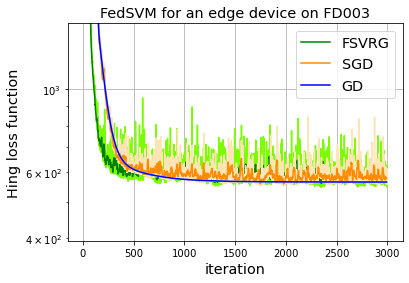

In [28]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
# plot costs
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.plot(cost_FSVRG, 'lawngreen')
plt.plot(running_mean(cost_FSVRG, 10), 'g', label="FSVRG")
plt.plot(cost_SGD, 'moccasin')
plt.plot(running_mean(cost_SGD, 10), 'darkorange', label="SGD")
plt.plot(cost_GD, 'lightblue')
plt.plot(running_mean(cost_GD, 10), 'b', label="GD")
plt.legend(loc="best", fontsize="x-large")
plt.yscale('log')
plt.title("FedSVM for an edge device on FD003", fontsize="x-large")
plt.ylabel("Hing loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
plt.ylim(0, 1500)
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD003/Results/"

plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("Hing loss function in FedSVM with 10 machines1 FD003.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("Hing loss function in FedSVM with 10 machines1 FD003.png", format='png', dpi=1200, bbox_inches='tight')


C:\Users\alibei\AppData\Local\Temp/ipykernel_12120/190967170.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


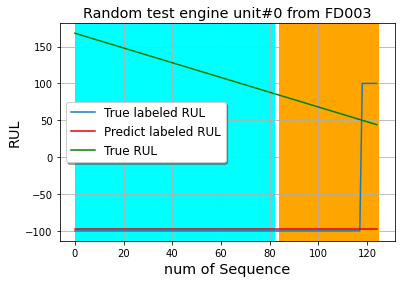

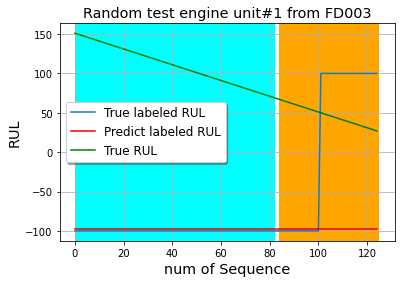

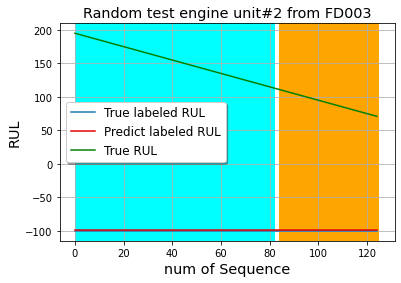

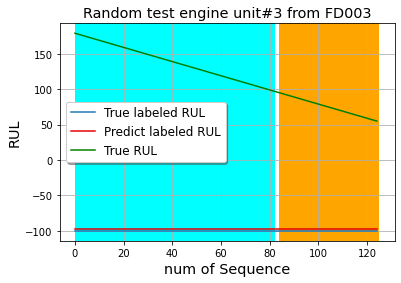

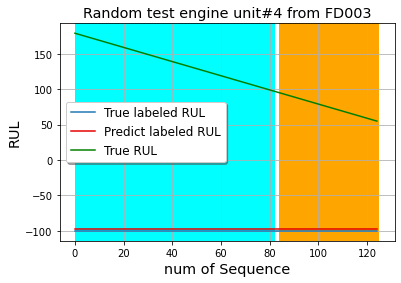

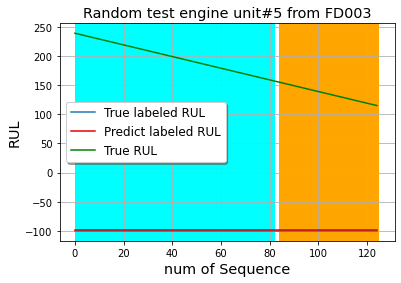

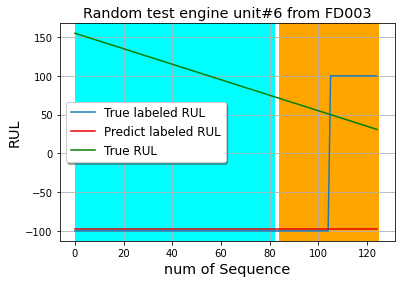

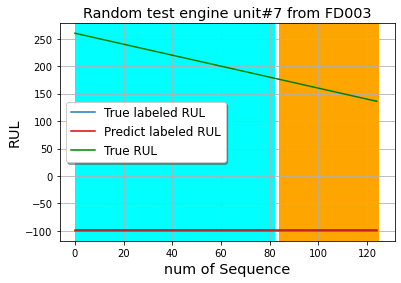

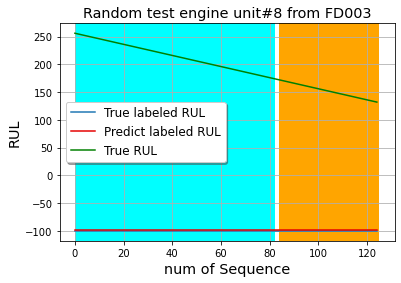

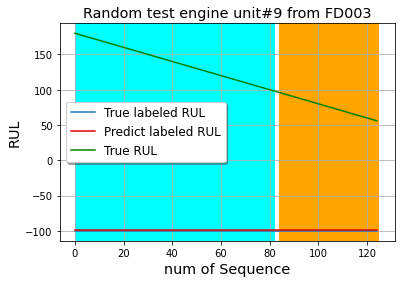

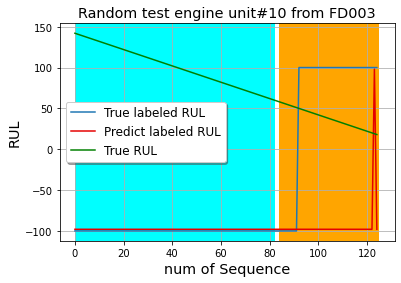

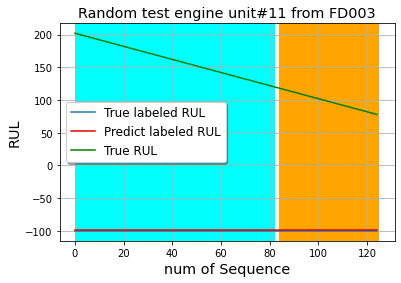

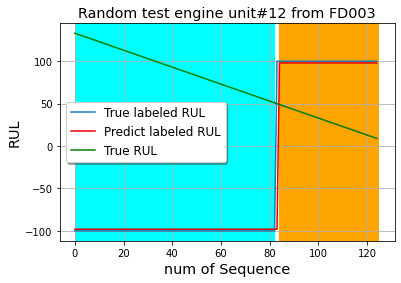

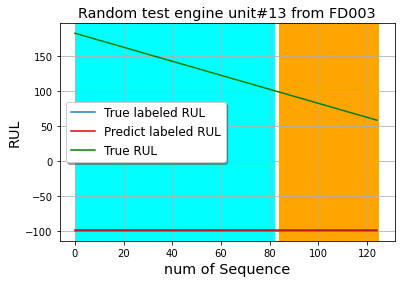

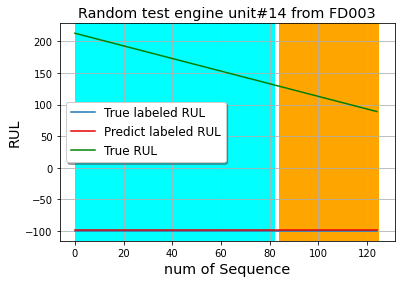

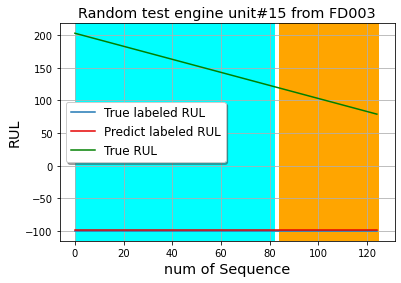

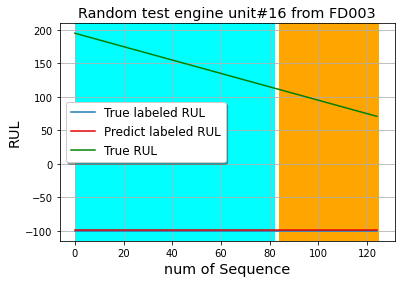

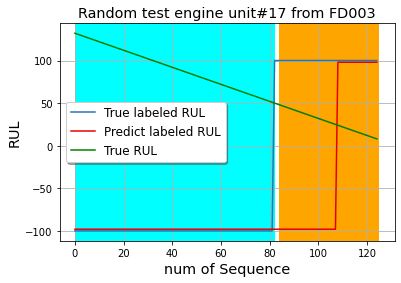

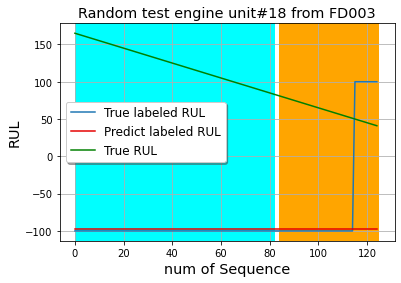

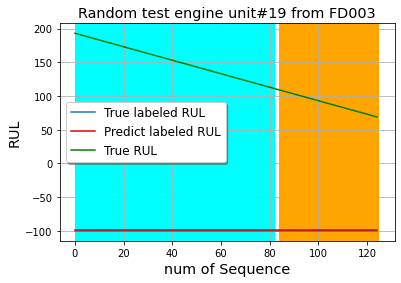

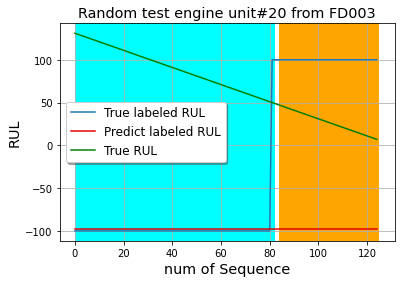

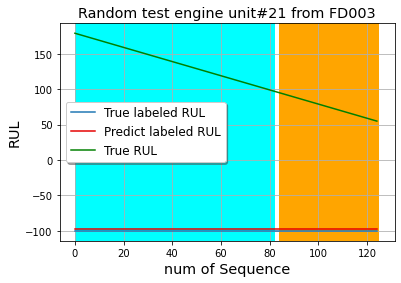

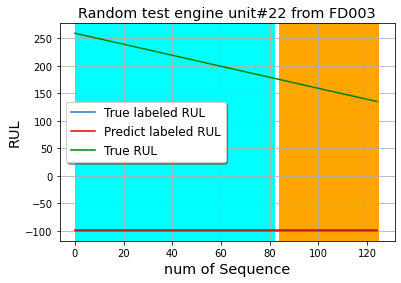

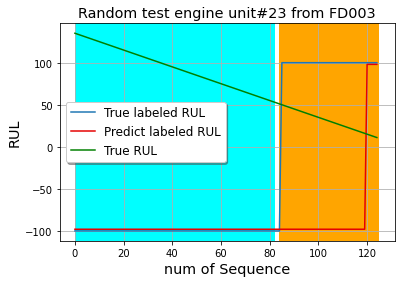

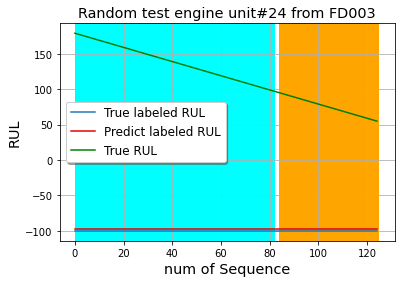

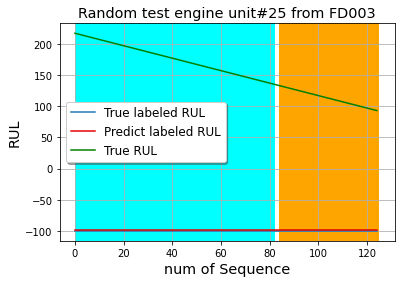

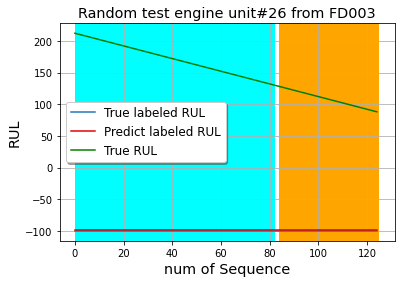

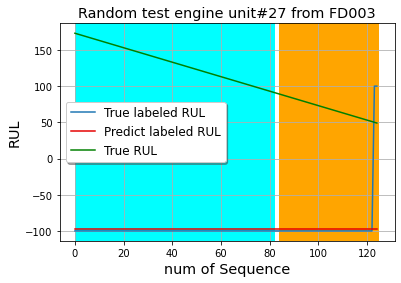

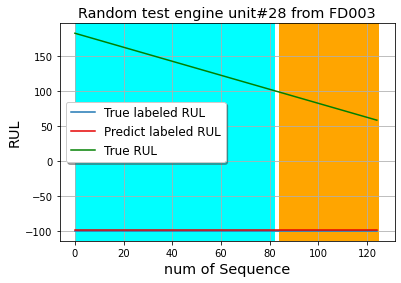

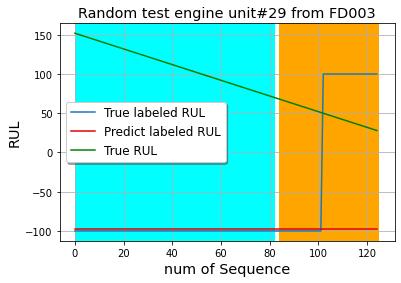

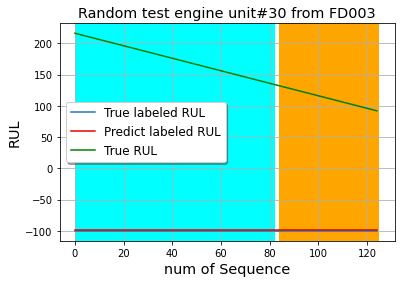

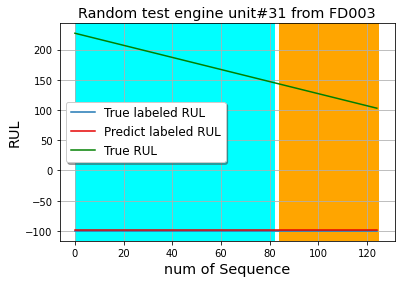

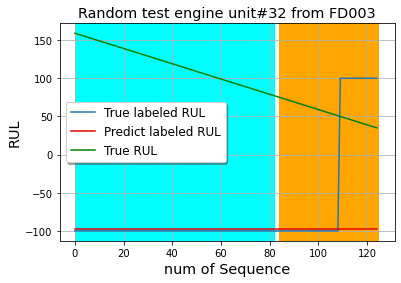

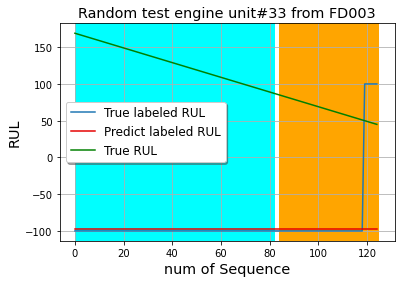

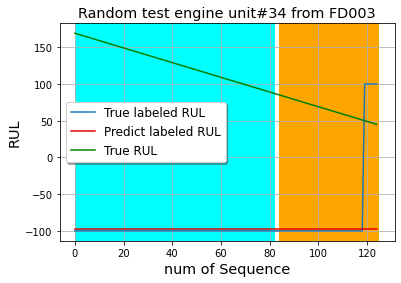

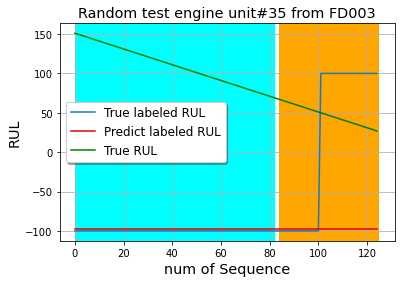

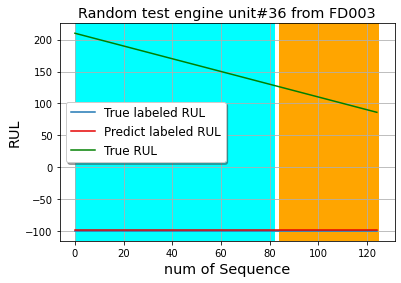

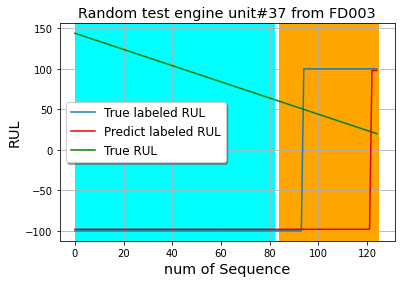

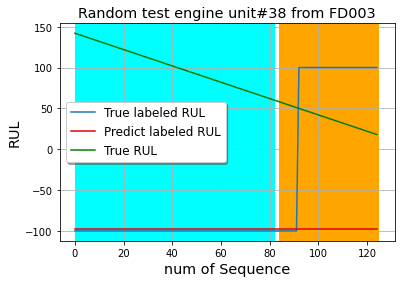

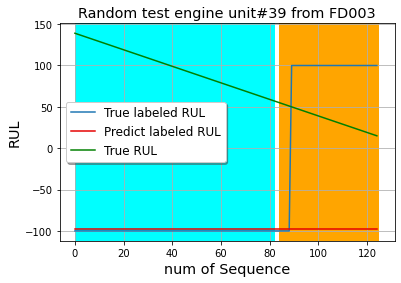

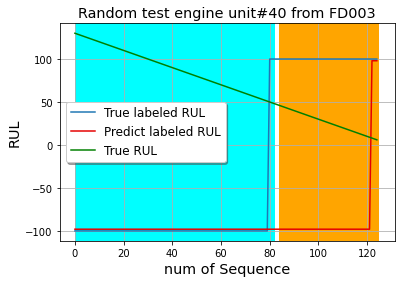

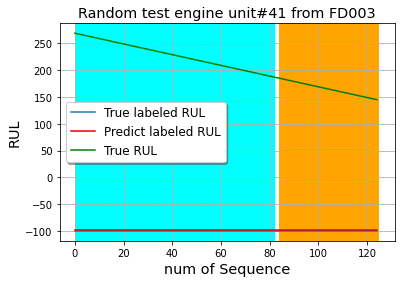

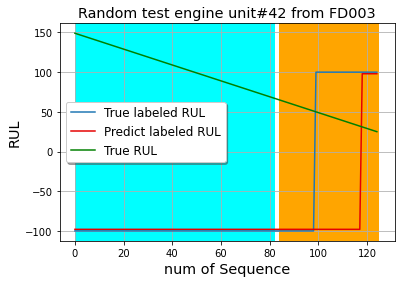

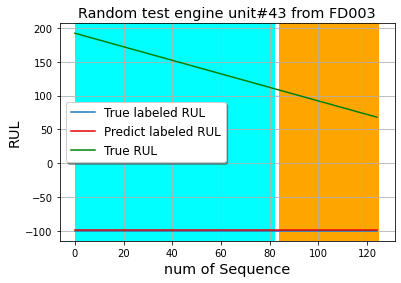

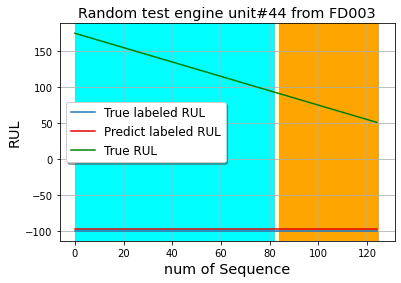

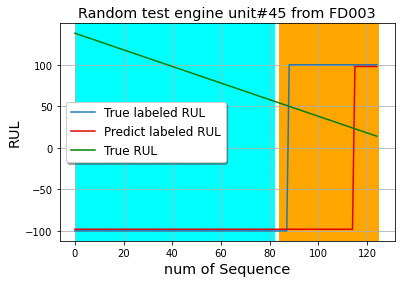

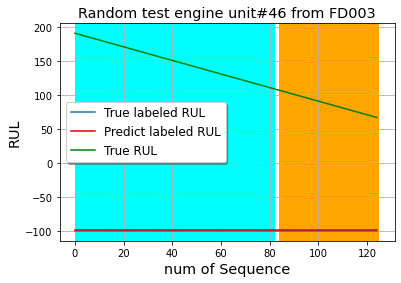

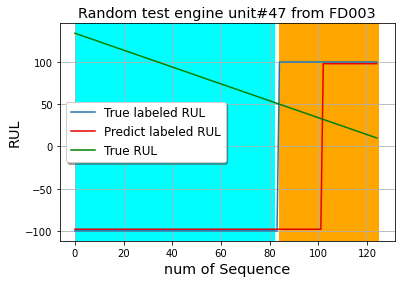

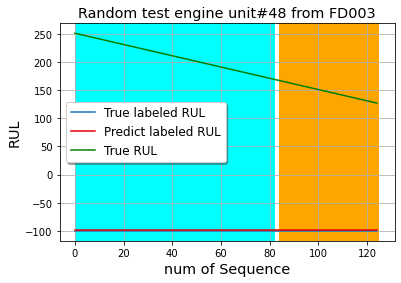

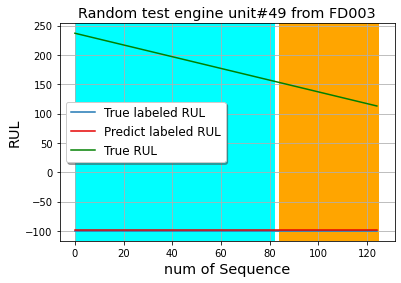

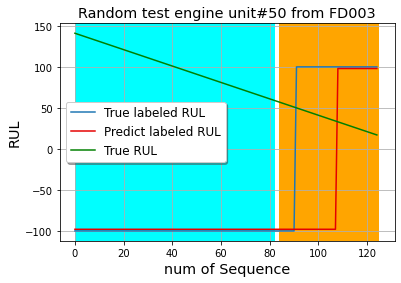

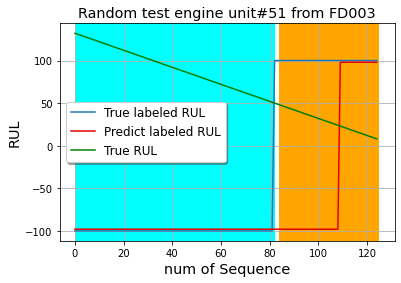

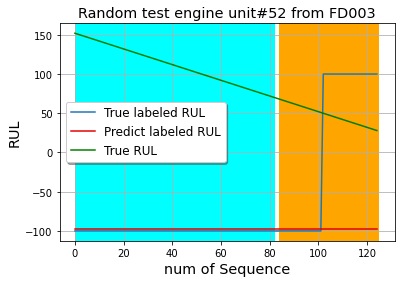

In [36]:
# Plot all the labels estimation with FedSVM for 100 master workers
fig = {}
ax = {}
for i in range(len(X_test_dic)):
    pre = predict(w_out_FSVRG, X_test_dic[i])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_test_dic[i] * 100, label='True labeled RUL')
    ax[i].plot(pre * 98, label='Predict labeled RUL', color='#E50000')
    ax[i].plot(Y_test_rul_dic[i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD003", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    #plt.xlabel("num of Sequence generated by windowing on input dataset", fontsize="x-large")
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].legend(shadow=True, fontsize='large')
    ax[i].grid()
    ax[i].axvspan(84, 125, facecolor='#FFA500')
    ax[i].axvspan(0, 82, facecolor='#00FFFF')

dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD003/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
#for i in range(len(X_test_dic)):
#    fig[i].savefig("FD003 Label prediction with FedSVM for machine number_" + str(i) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
#    fig[i].savefig("FD003 Label prediction with FedSVM for machine number_" + str(i) + ".png", format='png', dpi=1200, bbox_inches='tight')
        
        

In [37]:
# Save Specific figures
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD003/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[12].savefig("FD003 Label prediction with FedSVM for machine number_" + str(12) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[12].savefig("FD003 Label prediction with FedSVM for machine number_" + str(12) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
